In [1]:
import random
import pandas as pd
import numpy as np
import os

import torch
import torch.nn as nn
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.preprocessing import LabelEncoder
from prophet import Prophet
import re
import copy

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
seed_number = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(seed_number) # Seed 고정

In [4]:
drive_path = "/content/drive/MyDrive/데이터 경진대회/제주 특산물 가격 예측"
train_data_path = drive_path + "/train.csv"
test_data_path = drive_path + "/test.csv"
sample_submission_path = drive_path + "/sample_submission.csv"

In [5]:
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

In [6]:
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])

In [7]:
category_list = train_df["ID"].str.replace(r'_\d{8}$', '', regex=True).unique()

### 해당 날짜의 가격이 0인지 0이 아닌지를 판단하는 모델 설계

In [8]:
class BinaryLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size, device):
    super(BinaryLSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    out = self.sigmoid(out)
    return out

In [9]:
def label_encoding_category_columns_and_get_label_encoder(train_df, test_df, category_columns):
  le_dict = {}
  for column in category_columns:
    le = LabelEncoder()
    train_df[column] = le.fit_transform(train_df[column])
    test_df[column] = le.transform(test_df[column])
  return le_dict

In [10]:
batch_size = 256
seq_len = 356

In [11]:
qual_col = ['item', 'corporation', 'location']

le_dict = label_encoding_category_columns_and_get_label_encoder(train_df, test_df, qual_col)

In [12]:
train_df.head(5)

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,4,0,0,0.0,0.0
1,TG_A_J_20190102,2019-01-02,4,0,0,0.0,0.0
2,TG_A_J_20190103,2019-01-03,4,0,0,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,4,0,0,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,4,0,0,32352.0,1250.0


In [13]:
def handle_data_to_binary_lstm(df) :
  transformed_df = df[["ID", "timestamp", "item", "corporation", "location", "price(원/kg)"]]
  transformed_df["timestamp"] = pd.to_datetime(df["timestamp"])
  transformed_df["ID"] = transformed_df["ID"].str.replace(r'_\d{8}$', '', regex=True)
  transformed_df["day of week"] = transformed_df["timestamp"].dt.dayofweek
  transformed_df["month"] = transformed_df["timestamp"].dt.month
  transformed_df["day of month"] = transformed_df["timestamp"].dt.day
  transformed_df = transformed_df.rename(columns={'timestamp': 'ds', 'price(원/kg)': 'y'})
  transformed_df.loc[transformed_df["y"] > 0, "y"] = 1
  return transformed_df.drop(columns=["ds"])

In [14]:
def separate_data_label(df, label_key, except_keys) :
  data = df.drop(columns=[label_key, *except_keys])
  label = df[label_key]
  return data, label

In [15]:
class BinaryLstmDataset(Dataset):
  def __init__(self, dataframe):
    self.data = dataframe[['day of week', 'month', 'day of month']].values
    self.labels = dataframe['y'].values

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    sample = {'input': torch.tensor(self.data[idx], dtype=torch.float32),
              'label': torch.tensor(self.labels[idx], dtype=torch.float32)}
    return sample

In [16]:
def build_lstm_dataset(df, seq, key_position) :
  x = []
  y = []

  for i in range(0, len(df) - seq):
    _x = df[i:i+seq, 1:]
    _y = df[i+seq, key_position]
    x.append(_x.astype(np.float32))
    y.append(_y)
  return np.array(x), np.array(y)

In [17]:
train_lstm_data = handle_data_to_binary_lstm(train_df)

In [21]:
test_df_with_empty_price = test_df.copy()
test_df_with_empty_price["price(원/kg)"] = 0
test_lstm_data = handle_data_to_binary_lstm(test_df_with_empty_price)

In [ ]:
test_lstm_data.head(5)

,ID,item,corporation,location,y,day of week,month,day of month
0,TG_A_J,4,0,0,0,5,3,4
1,TG_A_J,4,0,0,0,6,3,5
2,TG_A_J,4,0,0,0,0,3,6
3,TG_A_J,4,0,0,0,1,3,7
4,TG_A_J,4,0,0,0,2,3,8


In [ ]:
total_x, total_y = np.empty((0, seq_len, 7)), np.array([])
for category in category_list:
  current_category_data = train_lstm_data[train_lstm_data["ID"] == category]
  _x, _y = build_lstm_dataset(np.array(current_category_data), seq_len, 4)

  total_x = np.concatenate((total_x, _x), axis = 0)
  total_y = np.concatenate((total_y, _y), axis = 0)

In [ ]:
_train_x_tensor = torch.FloatTensor(total_x).to(device)
_train_y_tensor = torch.FloatTensor(total_y).to(device)
lstm_dataset = TensorDataset(_train_x_tensor, _train_y_tensor)
lstm_dataloader = DataLoader(lstm_dataset, batch_size, shuffle=True)

In [ ]:
train_dataloader, val_dataloader = random_split(lstm_dataset, [0.8, 0.2])

In [ ]:
train_dataloader = DataLoader(train_dataloader, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataloader, batch_size=batch_size, shuffle=False)

In [18]:
binary_lstm_model = BinaryLSTM(7, seq_len, 1, 2, device).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(binary_lstm_model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
iter = 100

In [ ]:
len(train_dataloader)

143

In [19]:
binary_lstm_model.load_state_dict(torch.load(drive_path + f"/binary_lstm_weight.pt", map_location=torch.device(device)))

<All keys matched successfully>

In [ ]:
for epoch in range(iter) :
  binary_lstm_model.train()

  for i, batch in enumerate(train_dataloader):
    inputs = batch[0]#.to(device)
    labels = batch[1].long()#.to(device)
    outputs = binary_lstm_model(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 20 == 19 :
      print(f"Epoch {epoch + 1} / {iter} - {i}, train loss : {loss:.4f}")

  scheduler.step()
  binary_lstm_model.eval()
  with torch.no_grad():
    val_loss = 0

    for inputs, labels in val_dataloader:
      outputs = binary_lstm_model(inputs)
      val_loss += criterion(outputs, labels.long())

    avg_val_loss = val_loss / len(val_dataloader)
    print(f"Epoch {epoch + 1} / {iter}, valiodation loss : {avg_val_loss:.4f}")

    if avg_val_loss < min_val_loss :
      print(f"model weight saved! valiodation loss : {min_val_loss:.4f} -> {avg_val_loss:.4f}")
      min_val_loss = avg_val_loss
      weight_path = drive_path + f"/binary_lstm_weight.pt"
      torch.save(binary_lstm_model.state_dict(), weight_path)

In [ ]:
train_lstm_data.tail(5)

,ID,item,corporation,location,y,day of week,month,day of month
59392,RD_F_J,3,5,0,1.0,0,2,27
59393,RD_F_J,3,5,0,1.0,1,2,28
59394,RD_F_J,3,5,0,1.0,2,3,1
59395,RD_F_J,3,5,0,1.0,3,3,2
59396,RD_F_J,3,5,0,1.0,4,3,3


In [83]:
non_zero_dict = {}
for category in category_list :
  current_category_data = train_lstm_data[train_lstm_data["ID"] == category].iloc[-seq_len:]
  current_category_data = current_category_data.drop(columns=["ID"])

  current_category_predict_data = test_lstm_data[test_lstm_data["ID"] == category]
  current_category_predict_data = current_category_predict_data.drop(columns=["ID"])

  predict_steps = len(current_category_predict_data)

  predict_list = []
  for i in range(predict_steps) :
    current_input = pd.concat([current_category_data[i:], current_category_predict_data[:i]], axis=0)
    input_tensor = torch.tensor(current_input.values, dtype=torch.float32)
    input_tensor = input_tensor[None, :]

    with torch.no_grad():
      binary_lstm_model.eval()
      output = binary_lstm_model(input_tensor).tolist()[0]
      predict = output.index(max(output))

    current_category_predict_data.loc[current_category_predict_data.index[i], "y"] = predict
    predict_list.append(predict)

  non_zero_dict[category] = predict_list
  print(f"{category} non-zero predict is done!")

TG_A_J non-zero predict is done!
TG_A_S non-zero predict is done!
TG_B_J non-zero predict is done!
TG_B_S non-zero predict is done!
TG_C_J non-zero predict is done!
TG_C_S non-zero predict is done!
TG_D_J non-zero predict is done!
TG_D_S non-zero predict is done!
TG_E_J non-zero predict is done!
TG_E_S non-zero predict is done!
CR_A_J non-zero predict is done!
CR_B_J non-zero predict is done!
CR_C_J non-zero predict is done!
CR_D_J non-zero predict is done!
CR_D_S non-zero predict is done!
CR_E_J non-zero predict is done!
CR_E_S non-zero predict is done!
CB_A_J non-zero predict is done!
CB_A_S non-zero predict is done!
CB_D_J non-zero predict is done!
CB_E_J non-zero predict is done!
RD_A_J non-zero predict is done!
RD_A_S non-zero predict is done!
RD_C_S non-zero predict is done!
RD_D_J non-zero predict is done!
RD_D_S non-zero predict is done!
RD_E_J non-zero predict is done!
RD_E_S non-zero predict is done!
BC_A_J non-zero predict is done!
BC_A_S non-zero predict is done!
BC_B_J non

In [85]:
if len(non_zero_dict["TG_A_J"]) > 0:
  original_non_zero_dict = non_zero_dict.copy()

In [86]:
def get_average_of_list(lst):
    return sum(lst) / len(lst)

In [87]:
for category in category_list :
  current_non_zero_list = original_non_zero_dict[category]
  print(f"{category} : {round(get_average_of_list(current_non_zero_list), 2)}")

TG_A_J : 0.86
TG_A_S : 0.86
TG_B_J : 0.86
TG_B_S : 0.86
TG_C_J : 0.86
TG_C_S : 0.86
TG_D_J : 0.82
TG_D_S : 0.86
TG_E_J : 0.86
TG_E_S : 0.86
CR_A_J : 0.86
CR_B_J : 0.0
CR_C_J : 0.75
CR_D_J : 0.86
CR_D_S : 0.0
CR_E_J : 0.86
CR_E_S : 0.0
CB_A_J : 0.71
CB_A_S : 0.89
CB_D_J : 0.86
CB_E_J : 0.0
RD_A_J : 0.86
RD_A_S : 0.86
RD_C_S : 0.0
RD_D_J : 0.0
RD_D_S : 0.86
RD_E_J : 0.86
RD_E_S : 0.0
BC_A_J : 0.86
BC_A_S : 0.86
BC_B_J : 0.86
BC_B_S : 0.0
BC_C_J : 0.86
BC_C_S : 0.0
BC_D_J : 0.86
BC_E_J : 0.86
BC_E_S : 0.86
CB_F_J : 0.86
RD_F_J : 0.86


### 데이터 전처리
- 가격이 0이 아닌 데이터 사이에 너무 큰 공백을 막기 위해, 0이 아닌 데이터간의 간격이 90일을 넘어간 경우 15일 간격으로중간 날짜에 y=0인 임시 데이터를 insert

In [26]:
def handle_data_to_prophet(df) :
  transformed_df = df[["ID", "timestamp", "price(원/kg)"]]
  transformed_df["ID"] = transformed_df["ID"].str.replace(r'_\d{8}$', '', regex=True)
  transformed_df = transformed_df.rename(columns={'timestamp': 'ds', 'price(원/kg)': 'y'})
  return transformed_df.copy()

In [27]:
prophet_train_data = handle_data_to_prophet(train_df)

In [28]:
prophet_train_data.head(5)

,ID,ds,y
0,TG_A_J,2019-01-01,0.0
1,TG_A_J,2019-01-02,0.0
2,TG_A_J,2019-01-03,1728.0
3,TG_A_J,2019-01-04,1408.0
4,TG_A_J,2019-01-05,1250.0


In [133]:
test_target_category = "CB_A_J"

In [134]:
search_data = prophet_train_data[prophet_train_data["ID"] == test_target_category].drop(columns=["ID"]).sort_values("ds").copy()

In [135]:
train_size = int(len(search_data) * 0.8)
origin_train_data = search_data[:train_size]
# 만약 0을 제외하고 사용하려면 아래 줄 주석을 해제하세요
origin_train_data = origin_train_data[origin_train_data["y"] > 0]
origin_test_data = search_data[train_size:]

In [69]:
from datetime import datetime, timedelta
def insert_rows(df):
    result_df = pd.DataFrame(columns=df.columns)

    for i in range(len(df) - 1):
        current_row = df.iloc[i]
        next_row = df.iloc[i + 1]

        result_df = result_df.append(current_row, ignore_index=True)

        date_diff = (next_row['ds'] - current_row['ds']).days

        if date_diff > 90:
            for j in range(14, date_diff - 15, 15):
                new_date = current_row['ds'] + timedelta(days=j)
                new_row = {'y' : 0, 'ds' : new_date}
                result_df = result_df.append(new_row, ignore_index=True)

    result_df = result_df.append(df.iloc[-1], ignore_index=True)

    return result_df

In [136]:
test_data = search_data[:train_size]
test_data = test_data[test_data["y"] > 0]
test_data = insert_rows(test_data)

In [137]:
test_data.head()

,ds,y
0,2019-01-05,374.0
1,2019-01-08,250.0
2,2019-01-09,273.0
3,2019-01-19,321.0
4,2019-01-24,548.0


In [138]:
import matplotlib.pyplot as plt

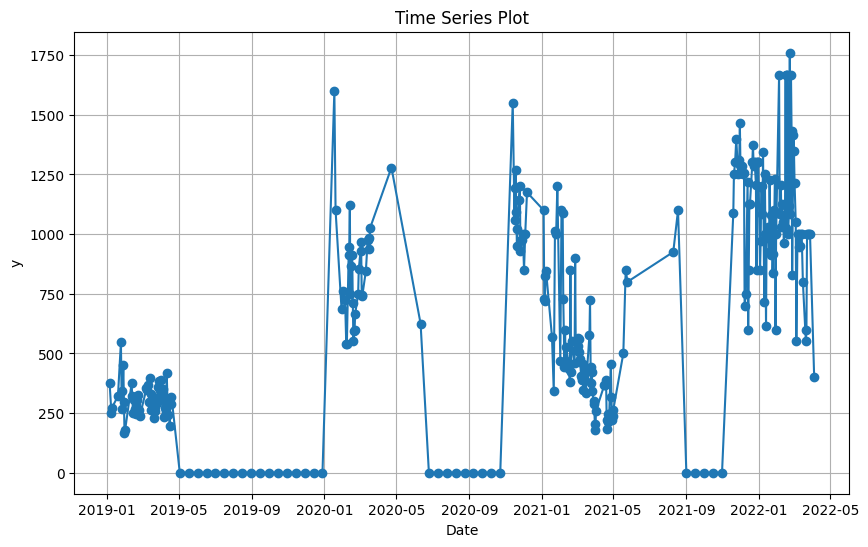

In [139]:
plt.figure(figsize=(10, 6))
plt.plot(test_data['ds'], test_data['y'], marker='o', linestyle='-')
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('y')
plt.grid(True)
plt.show()

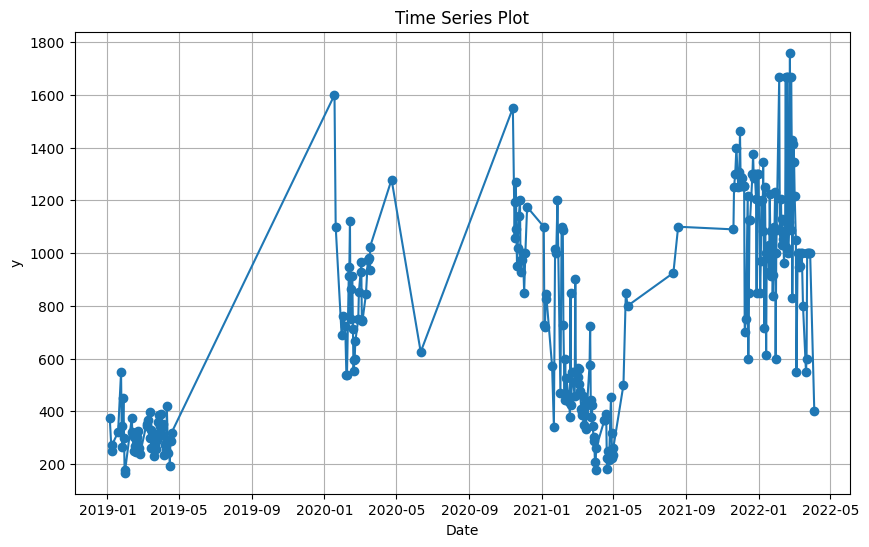

In [140]:
plt.figure(figsize=(10, 6))
plt.plot(origin_train_data['ds'], origin_train_data['y'], marker='o', linestyle='-')
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('y')
plt.grid(True)
plt.show()

### Prophet 히이퍼 파라미터 탐색

In [92]:
param_grid = {
    'growth': ['linear'],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 1, 5, 10],
    'seasonality_prior_scale': [0.01, 0.1, 1, 5, 10],
    'changepoint_range': [0.8, 0.85, 0.9, 0.95],
    'yearly_seasonality': [True, False],
    'weekly_seasonality': [True, False],
    'daily_seasonality': [True, False],
    'holidays_prior_scale': [0.1, 1, 5],
}

In [88]:
# 가격값이 0이 아닌 데이터의 비중이 0.6 이상인 카테고리에 대해서만 하이퍼 파라미터 탐색을 수행할 예정.
search_hyper_category_list = []
for category in category_list :
  current_non_zero_list = original_non_zero_dict[category]
  if round(get_average_of_list(current_non_zero_list), 2) > 0.6:
    search_hyper_category_list.append(category)

In [90]:
def prophet_grid_search(num_iterations, param_grid, train_data, y):
  results = []

  for _ in range(num_iterations) :
    random_params = {
        key : random.choice(value) for key, value in param_grid.items()
    }

    current_model = Prophet(**random_params)
    current_model.fit(train_data)

    y_size = len(y)

    future = current_model.make_future_dataframe(periods=y_size)
    forecast = current_model.predict(future)
    m_predict = forecast["yhat"].values[-y_size:]

    se = np.square(m_predict - y)
    rmse = np.sqrt(np.mean(se))

    results.append((random_params, rmse))
  return results

In [ ]:
model_per_category = {}
for category in search_hyper_category_list:
  search_data = prophet_train_data[prophet_train_data["ID"] == category].drop(columns=["ID"]).sort_values("ds").copy()
  train_size = int(len(search_data) * 0.7)
  search_train_data = search_data[:train_size]
  # 만약 0을 제외하고 사용하려면 아래 줄 주석을 해제하세요
  search_train_data = search_train_data[search_train_data["y"] > 0]
  search_train_data = insert_rows(search_train_data)
  search_test_data = search_data[train_size:]
  y = search_test_data["y"].values[:]
  results = prophet_grid_search(30, param_grid, search_train_data, y)
  sorted_results = sorted(results, key=lambda x : x[1])[:5]
  model_per_category[category] = sorted_results

In [94]:
import json
file_path = drive_path + '/prophet_5.txt'
def save_prophet_params(dictionary, file_path):
  with open(file_path, 'w') as file :
    json.dump(dictionary, file)

def extract_prophet_params(file_path):
  with open(file_path, 'r') as file :
    loaded_dict = json.load(file)
  return loaded_dict

In [95]:
save_prophet_params(model_per_category, file_path)

In [96]:
saved_result = extract_prophet_params(file_path)
model_per_category = saved_result

In [110]:
test_result = model_per_category[test_target_category]

In [111]:
best_params, best_rmse = min(test_result, key=lambda x: x[1])
print(best_params)

{'growth': 'linear', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'changepoint_range': 0.95, 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'holidays_prior_scale': 5}


In [141]:
test_prophet_data = prophet_train_data[prophet_train_data["ID"] == test_target_category].drop(columns=["ID"]).sort_values("ds").copy()

In [142]:
train_size = int(len(test_prophet_data) * 0.7)
search_train_data = test_prophet_data[:train_size]
search_train_data = search_train_data[search_train_data["y"] > 0]
search_train_data = insert_rows(search_train_data)
search_test_data = test_prophet_data[train_size:]

In [143]:
search_train_data

,ds,y
0,2019-01-05,374.0
1,2019-01-08,250.0
2,2019-01-09,273.0
3,2019-01-19,321.0
4,2019-01-24,548.0
...,...,...
210,2021-11-26,1300.0
211,2021-11-27,1252.0
212,2021-11-29,1309.0
213,2021-11-30,1464.0


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/ylpri6ii.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/gyj2696b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49683', 'data', 'file=/tmp/tmpyxm60w1x/ylpri6ii.json', 'init=/tmp/tmpyxm60w1x/gyj2696b.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_model9u_ao95a/prophet_model-20231116140429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:04:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:04:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


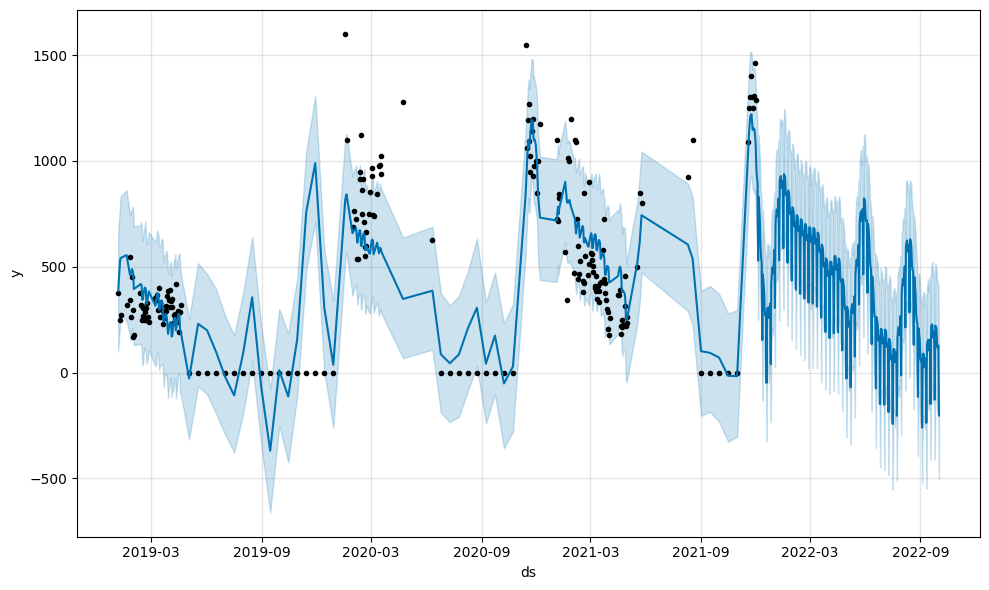

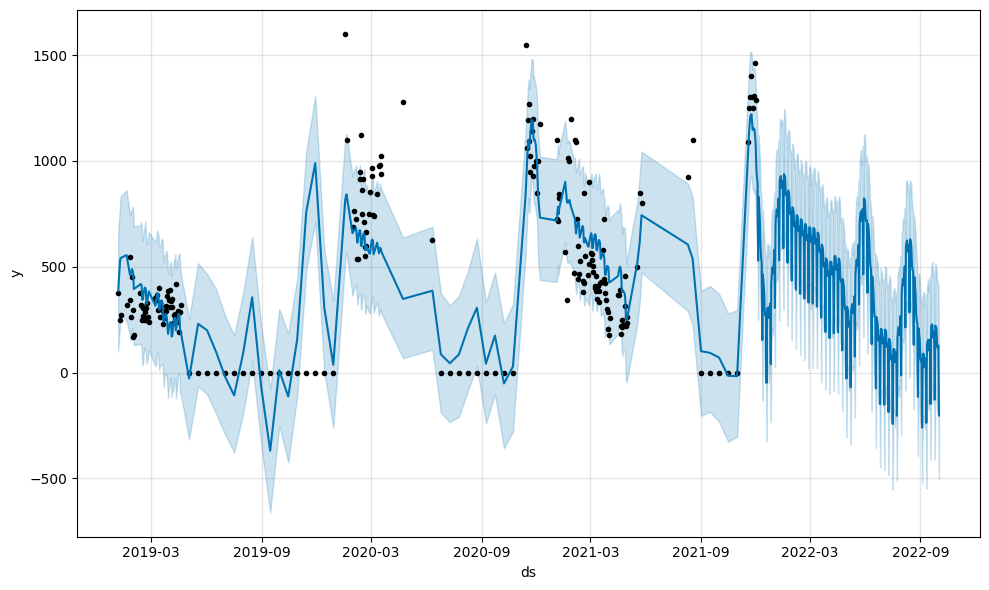

In [146]:
test_model = Prophet(**best_params)
test_model.fit(search_train_data)
future = test_model.make_future_dataframe(periods=305)
forecast = test_model.predict(future)
test_model.plot(forecast)

In [145]:
prophet_map = {}

In [119]:
for category in category_list :
  if category in model_per_category.keys():
    category_prophet_result = model_per_category[category]
    best_params, best_rmse = min(category_prophet_result, key=lambda x: x[1])
    main_model = Prophet(**best_params)
  else :
    main_model = Prophet()
  current_category_train_x = prophet_train_data[prophet_train_data["ID"] == category].drop(columns=["ID"]).sort_values("ds")
  current_category_train_x = current_category_train_x[current_category_train_x["y"] > 0]
  current_category_train_x = insert_rows(current_category_train_x)

  prophet_map[category] = main_model.fit(current_category_train_x)
  print(f"{category} category fit complete!")

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/07vq2ihu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/r83z5b49.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82500', 'data', 'file=/tmp/tmpyxm60w1x/07vq2ihu.json', 'init=/tmp/tmpyxm60w1x/r83z5b49.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_modelc8bemdjt/prophet_model-20231116135048.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:50:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:50:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


TG_A_J category fit complete!


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/mklxzgt9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/wzhvyq36.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6628', 'data', 'file=/tmp/tmpyxm60w1x/mklxzgt9.json', 'init=/tmp/tmpyxm60w1x/wzhvyq36.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_modelmc064eg8/prophet_model-20231116135051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:50:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:50:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


TG_A_S category fit complete!


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/iggfch8h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/d7eaeo0f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56825', 'data', 'file=/tmp/tmpyxm60w1x/iggfch8h.json', 'init=/tmp/tmpyxm60w1x/d7eaeo0f.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_model8ykqq7l2/prophet_model-20231116135054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:50:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:50:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


TG_B_J category fit complete!


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/eunywh4b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/go9du1u7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58744', 'data', 'file=/tmp/tmpyxm60w1x/eunywh4b.json', 'init=/tmp/tmpyxm60w1x/go9du1u7.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_modelfrsdmmna/prophet_model-20231116135058.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:50:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:50:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


TG_B_S category fit complete!


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/x4lwjtmw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/rd59owif.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30346', 'data', 'file=/tmp/tmpyxm60w1x/x4lwjtmw.json', 'init=/tmp/tmpyxm60w1x/rd59owif.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_modelb8vrjz7n/prophet_model-20231116135100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


TG_C_J category fit complete!


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/ivy2h34v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/jc48v137.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43642', 'data', 'file=/tmp/tmpyxm60w1x/ivy2h34v.json', 'init=/tmp/tmpyxm60w1x/jc48v137.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_modelyrs0ddq_/prophet_model-20231116135103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


TG_C_S category fit complete!


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/en7n611l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/5w43n1ye.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21694', 'data', 'file=/tmp/tmpyxm60w1x/en7n611l.json', 'init=/tmp/tmpyxm60w1x/5w43n1ye.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_model3g3jt4l2/prophet_model-20231116135105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


TG_D_J category fit complete!


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/igc6pej6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/v383lb60.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62240', 'data', 'file=/tmp/tmpyxm60w1x/igc6pej6.json', 'init=/tmp/tmpyxm60w1x/v383lb60.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_modeluc882xeg/prophet_model-20231116135107.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


TG_D_S category fit complete!


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/eh1gh4hg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/xs92d3es.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78438', 'data', 'file=/tmp/tmpyxm60w1x/eh1gh4hg.json', 'init=/tmp/tmpyxm60w1x/xs92d3es.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_model8kakmskc/prophet_model-20231116135110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


TG_E_J category fit complete!


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/eujo_ybp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/lqcedi62.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65186', 'data', 'file=/tmp/tmpyxm60w1x/eujo_ybp.json', 'init=/tmp/tmpyxm60w1x/lqcedi62.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_modelqmezblm4/prophet_model-20231116135114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


TG_E_S category fit complete!


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/ok2wj0la.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/am9yge6z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62657', 'data', 'file=/tmp/tmpyxm60w1x/ok2wj0la.json', 'init=/tmp/tmpyxm60w1x/am9yge6z.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_modelpwnnexak/prophet_model-20231116135115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:51:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/fx5j3bpg.json
DE

CR_A_J category fit complete!


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/31xrwzys.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/t9v89uau.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98022', 'data', 'file=/tmp/tmpyxm60w1x/31xrwzys.json', 'init=/tmp/tmpyxm60w1x/t9v89uau.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_modela_25avvc/prophet_model-20231116135116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CR_B_J category fit complete!


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/o4t454hu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/rffroxki.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21576', 'data', 'file=/tmp/tmpyxm60w1x/o4t454hu.json', 'init=/tmp/tmpyxm60w1x/rffroxki.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_modely4hafr21/prophet_model-20231116135117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CR_C_J category fit complete!


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/m09ol4yd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/jzmiaf8v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54504', 'data', 'file=/tmp/tmpyxm60w1x/m09ol4yd.json', 'init=/tmp/tmpyxm60w1x/jzmiaf8v.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_modelhl40d76c/prophet_model-20231116135118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CR_D_J category fit complete!


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/hzzbkxwc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/cixvag07.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88668', 'data', 'file=/tmp/tmpyxm60w1x/hzzbkxwc.json', 'init=/tmp/tmpyxm60w1x/cixvag07.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_modelinopwu6r/prophet_model-20231116135119.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:51:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CR_D_S category fit complete!


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/zqzx7ww_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/o7h_mgah.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69523', 'data', 'file=/tmp/tmpyxm60w1x/zqzx7ww_.json', 'init=/tmp/tmpyxm60w1x/o7h_mgah.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_model816517ac/prophet_model-20231116135121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/evf8jymr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/yef5oasm.json
DEBUG:cmdstanpy:

CR_E_J category fit complete!


13:51:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CR_E_S category fit complete!


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/e7ni8bzs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/8pg8olxt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7243', 'data', 'file=/tmp/tmpyxm60w1x/e7ni8bzs.json', 'init=/tmp/tmpyxm60w1x/8pg8olxt.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_modelst69h5da/prophet_model-20231116135123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CB_A_J category fit complete!


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/d6dhub9w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/7aqwynu2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59541', 'data', 'file=/tmp/tmpyxm60w1x/d6dhub9w.json', 'init=/tmp/tmpyxm60w1x/7aqwynu2.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_modelmx_xsc9a/prophet_model-20231116135124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:51:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/udsjgyb0.json
DE

CB_A_S category fit complete!


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/_qqiraz3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/2_7gms65.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41838', 'data', 'file=/tmp/tmpyxm60w1x/_qqiraz3.json', 'init=/tmp/tmpyxm60w1x/2_7gms65.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_modelvxwnk12u/prophet_model-20231116135125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CB_D_J category fit complete!


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/7z_hfxcf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/q3gx62n7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90083', 'data', 'file=/tmp/tmpyxm60w1x/7z_hfxcf.json', 'init=/tmp/tmpyxm60w1x/q3gx62n7.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_model7bgotiks/prophet_model-20231116135126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CB_E_J category fit complete!


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/r_vbwc4l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/q0paquj6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38083', 'data', 'file=/tmp/tmpyxm60w1x/r_vbwc4l.json', 'init=/tmp/tmpyxm60w1x/q0paquj6.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_model1vmbxnsx/prophet_model-20231116135128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RD_A_J category fit complete!


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/fxu955jx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/mmouyx9r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37427', 'data', 'file=/tmp/tmpyxm60w1x/fxu955jx.json', 'init=/tmp/tmpyxm60w1x/mmouyx9r.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_modelgko14q0w/prophet_model-20231116135129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RD_A_S category fit complete!


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/ss2enbod.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/ttu9ibkp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43178', 'data', 'file=/tmp/tmpyxm60w1x/ss2enbod.json', 'init=/tmp/tmpyxm60w1x/ttu9ibkp.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_modelipg_1zx3/prophet_model-20231116135131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RD_C_S category fit complete!


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/g0xfbn06.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/jfxrd0s5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80089', 'data', 'file=/tmp/tmpyxm60w1x/g0xfbn06.json', 'init=/tmp/tmpyxm60w1x/jfxrd0s5.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_modeltt6nm378/prophet_model-20231116135132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RD_D_J category fit complete!


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/_pv3whfc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/lp9mqdcu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77135', 'data', 'file=/tmp/tmpyxm60w1x/_pv3whfc.json', 'init=/tmp/tmpyxm60w1x/lp9mqdcu.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_modeltee4mon1/prophet_model-20231116135133.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RD_D_S category fit complete!


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/v1aq9844.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/sqbwxch1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37585', 'data', 'file=/tmp/tmpyxm60w1x/v1aq9844.json', 'init=/tmp/tmpyxm60w1x/sqbwxch1.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_modelkn22hppj/prophet_model-20231116135134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RD_E_J category fit complete!


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/x3k9ua_3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/ivq5cit5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7045', 'data', 'file=/tmp/tmpyxm60w1x/x3k9ua_3.json', 'init=/tmp/tmpyxm60w1x/ivq5cit5.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_modelu993qerd/prophet_model-20231116135135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RD_E_S category fit complete!


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/whz3q517.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/egixjdb1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26702', 'data', 'file=/tmp/tmpyxm60w1x/whz3q517.json', 'init=/tmp/tmpyxm60w1x/egixjdb1.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_model8kx5g2ra/prophet_model-20231116135136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


BC_A_J category fit complete!


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/gmti_se0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/j3i0ovtz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87779', 'data', 'file=/tmp/tmpyxm60w1x/gmti_se0.json', 'init=/tmp/tmpyxm60w1x/j3i0ovtz.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_modelneifnrn5/prophet_model-20231116135138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


BC_A_S category fit complete!


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/2funwd7c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/px73iplg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69125', 'data', 'file=/tmp/tmpyxm60w1x/2funwd7c.json', 'init=/tmp/tmpyxm60w1x/px73iplg.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_modeludkp_kut/prophet_model-20231116135139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


BC_B_J category fit complete!


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/8k9naitq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/i09fl4sp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13827', 'data', 'file=/tmp/tmpyxm60w1x/8k9naitq.json', 'init=/tmp/tmpyxm60w1x/i09fl4sp.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_modelq781qmoa/prophet_model-20231116135139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


BC_B_S category fit complete!


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/tocg5mu1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/124_itom.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16455', 'data', 'file=/tmp/tmpyxm60w1x/tocg5mu1.json', 'init=/tmp/tmpyxm60w1x/124_itom.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_modelziu4c35n/prophet_model-20231116135140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/w1_4h21d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/qakxpy3e.json


BC_C_J category fit complete!


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76547', 'data', 'file=/tmp/tmpyxm60w1x/w1_4h21d.json', 'init=/tmp/tmpyxm60w1x/qakxpy3e.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_modelpnw7bgcu/prophet_model-20231116135141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


BC_C_S category fit complete!


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/w9kzlrt_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/wcyc_qde.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31379', 'data', 'file=/tmp/tmpyxm60w1x/w9kzlrt_.json', 'init=/tmp/tmpyxm60w1x/wcyc_qde.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_model9btrn487/prophet_model-20231116135143.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


BC_D_J category fit complete!


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/nr8n9ns6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/9epe8akv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70934', 'data', 'file=/tmp/tmpyxm60w1x/nr8n9ns6.json', 'init=/tmp/tmpyxm60w1x/9epe8akv.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_model0rc376tl/prophet_model-20231116135146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


BC_E_J category fit complete!


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/nm4_a5io.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/betc_63b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96677', 'data', 'file=/tmp/tmpyxm60w1x/nm4_a5io.json', 'init=/tmp/tmpyxm60w1x/betc_63b.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_modelhtke7h7a/prophet_model-20231116135148.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


BC_E_S category fit complete!


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/p_wm0xzs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/77zh08xs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54208', 'data', 'file=/tmp/tmpyxm60w1x/p_wm0xzs.json', 'init=/tmp/tmpyxm60w1x/77zh08xs.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_model6pqj8k2x/prophet_model-20231116135149.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CB_F_J category fit complete!


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/ublf3ilq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyxm60w1x/odrwkx3b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1189', 'data', 'file=/tmp/tmpyxm60w1x/ublf3ilq.json', 'init=/tmp/tmpyxm60w1x/odrwkx3b.json', 'output', 'file=/tmp/tmpyxm60w1x/prophet_modeld_ly7y8i/prophet_model-20231116135151.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RD_F_J category fit complete!


In [120]:
test_df["price(원/kg)"] = 0

In [121]:
prophet_test_data = handle_data_to_prophet(test_df)

In [122]:
result_map = {}
for category in category_list :
  current_category_test_x = prophet_test_data[prophet_test_data["ID"] == category].drop(columns=["ID"])
  model = prophet_map[category]
  y = model.predict(current_category_test_x)
  result_map[category] = y["yhat"].values.tolist()

In [123]:
copy_result_map = copy.deepcopy(result_map)

In [124]:
def assign_result(row) :
  category = re.sub(r'_\d{8}$', '', row["ID"])
  result = copy_result_map[category]
  non_zero = non_zero_dict[category]
  return result.pop(0) * non_zero.pop(0)

In [125]:
submission = pd.read_csv(sample_submission_path)

In [126]:
submission.head()

,ID,answer
0,TG_A_J_20230304,0
1,TG_A_J_20230305,0
2,TG_A_J_20230306,0
3,TG_A_J_20230307,0
4,TG_A_J_20230308,0


In [127]:
submission["answer"] = 0

In [128]:
submission["answer"] = submission.apply(assign_result, axis=1)

In [129]:
submission.tail(50)

,ID,answer
1042,CB_F_J_20230310,574.544966
1043,CB_F_J_20230311,574.486948
1044,CB_F_J_20230312,0.000000
1045,CB_F_J_20230313,574.370914
1046,CB_F_J_20230314,574.312896
1047,CB_F_J_20230315,574.254879
1048,CB_F_J_20230316,574.196861
1049,CB_F_J_20230317,574.138844
1050,CB_F_J_20230318,574.080826
1051,CB_F_J_20230319,0.000000


In [130]:
submission.loc[submission["answer"] < 0, "answer"] = 0

In [131]:
submission[submission["answer"] < 0]

,ID,answer


In [132]:
submission.to_csv(drive_path + "/submission_231116_2.csv", index=False)

In [ ]:
len(category_list)

39